In [59]:
import useful as us

import numpy as np
import cv2
import matplotlib.pyplot as plt

import useful as us
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.ndimage
from scipy.ndimage import convolve
import skimage.feature

In [78]:
def match_SIFT_img(im1, im2, thres = 0.6):
    ''' Extract the coordinates of matching points using SIFT.'''    
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    
    # Find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    
    for m, n in matches:
        if m.distance/(n.distance+10e-10) < thres:
            good_matches.append([m])
    
    # Extract the coordinates
    pts_im1 = [kp1[m[0].queryIdx].pt for m in good_matches]
    pts_im1 = np.array(pts_im1, dtype=np.float32).T
    pts_im2 = [kp2[m[0].trainIdx].pt for m in good_matches]
    pts_im2 = np.array(pts_im2, dtype=np.float32).T
    return pts_im1, pts_im2

In [61]:
def plot_matching_keypoints(im1, im2, pts_im1, pts_im2):
    ''' Plot SIFT matches.'''    

    # Making mosaic image
    r1, c1 = im1.shape
    r2, c2 = im2.shape
    n_row = np.maximum(r1, r2)
    n_col = c1 + c2
    im_comp = np.zeros((n_row, n_col))
    im_comp[:r1, :c1] = im1
    im_comp[:r2, c1:(c1+c2)] = im2
    
    # Plot mosaic and matches
    fig, ax = plt.subplots(1,figsize=(10,8))
    ax.imshow(im_comp, cmap='gray')
    ax.plot([pts_im1[0], pts_im2[0] + c1], 
            [pts_im1[1], pts_im2[1]], 'w', linewidth = 0.5)
    ax.plot(pts_im1[0], pts_im1[1], '.r')
    ax.plot(pts_im2[0] + c1, pts_im2[1],' .b')

In [62]:
def get_transformation(p, q):
    '''
    Compute the transformation parameters of hte equation:
        q = s*R@p + t

    Parameters
    ----------
    p : numpy array
        2 x n array of points.
    q : numpy array
        2 x n array of points. p and q corresponds.

    Returns
    -------
    R : numpy array
        2 x 2 rotation matrix.
    t : numpy array
        2 x 1 translation matrix.
    s : float
        scale parameter.

    '''

    # Calculate the centroids
    m_p = np.mean(p, axis=1, keepdims=True)
    m_q = np.mean(q, axis=1, keepdims=True)

    # Calculate the scale, rotation and translation
    s = np.linalg.norm(q - m_q)/np.linalg.norm(p - m_p)
    
    # Compute the covariance matrix
    C = (q - m_q) @ (p - m_p).T

    # Singular value decomposition
    U, S, Vt = np.linalg.svd(C)
    
    # Initial rotation matrix
    R_ = U @ Vt

    # Adjusting for reflection
    R = R_ @ np.array([[1, 0], [0, np.linalg.det(R_)]])
    
    # Translation
    t = m_q - s * R@m_p
    return R, t, s

# SIFT between images

In [63]:
# Data directory
data_dir = 'data_week3/'

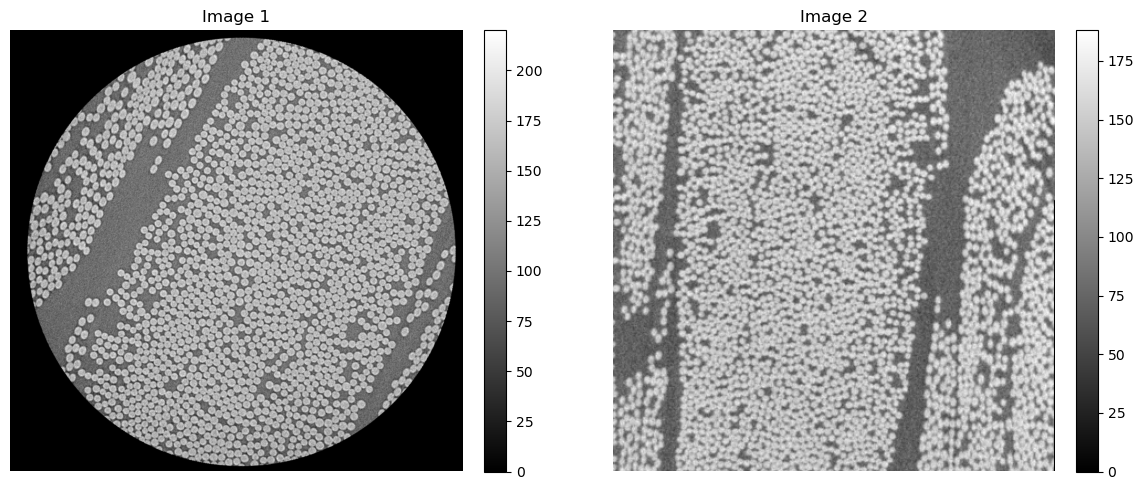

In [64]:
# The images
im1 = cv2.imread(data_dir + 'quiz_image_1.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(data_dir + 'quiz_image_2.png', cv2.IMREAD_GRAYSCALE)

# Display the images
us.display_images([im1, im2], ['Image 1', 'Image 2'])

In [79]:
# Match points with SIFT
threshold = 0.5
pts_im1, pts_im2 = match_SIFT_img(im1, im2, thres = threshold)

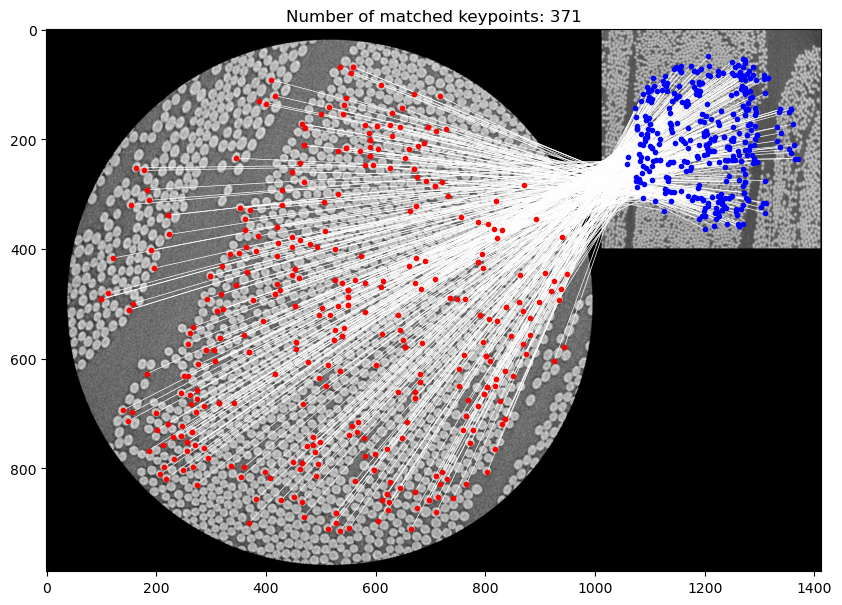

In [66]:
plot_matching_keypoints(im1, im2, pts_im1, pts_im2)
plt.title(f'Number of matched keypoints: {pts_im1.shape[1]}')
plt.show()

# SIFT between points with descriptors

In [82]:
def sift_matching_translation(sift_1_coord, sift_2_coord, sift_1_desc, sift_2_desc):
    """
    Computes the translation vector and its length between two sets of SIFT features.
    
    Returns:
    - mean_translation: The mean translation vector as a numpy array of shape (2,).
    - translation_length: The length of the translation vector.
    - matched_distances: A list of distances between the SIFT feature from Image 1 and its closest match in Image 2.
    """

    coord_1 = sift_1_coord
    coord_2 = sift_2_coord
    desc_1 = sift_1_desc
    desc_2 = sift_2_desc

    # Create a list of translations and matched distances
    translations = []
    matched_distances = []

    # Compute distance between one descriptor in set a and all in set b
    for i, desc in enumerate(desc_1):
        d = ((desc - desc_2) ** 2).sum(axis=1)
        sorted_indices = np.argsort(d)
        
        # Apply ratio test as per Lowe's paper
        if d[sorted_indices[0]] / d[sorted_indices[1]] < 0.8:
            best_match_idx = sorted_indices[0]
            translations.append(coord_1[i] - coord_2[best_match_idx])
            dist = np.sqrt(((coord_1[i] - coord_2[best_match_idx]) ** 2).sum())
            matched_distances.append(dist)

    # Make array of translations and compute the mean
    if translations:
        translations = np.vstack(translations)
        mean_translation = translations.mean(axis=0)
        translation_length = np.linalg.norm(mean_translation)
    else:
        mean_translation = np.array([0, 0])
        translation_length = 0

    return mean_translation, translation_length, matched_distances

In [80]:
data_dir = 'data_2022/'

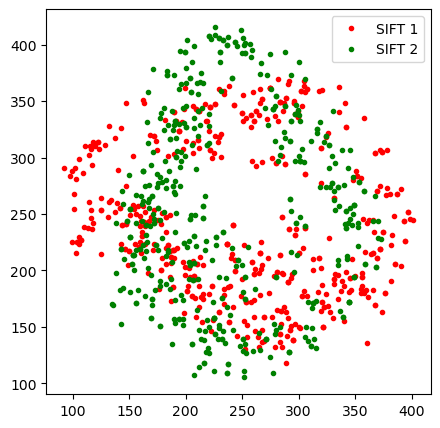

In [81]:
# Open the txt files
sift_1_coord = np.loadtxt(data_dir + 'SIFT_1_coordinates.txt')
sift_2_coord = np.loadtxt(data_dir + 'SIFT_2_coordinates.txt')


sift_1_desc = np.loadtxt(data_dir + 'SIFT_1_descriptors.txt')
sift_2_desc = np.loadtxt(data_dir + 'SIFT_2_descriptors.txt')

# Display the data
us.display_points([sift_1_coord, sift_2_coord], titles=['SIFT 1', 'SIFT 2'])

In [83]:
# Obtain the translations
mean_translation, translation_length, matched_distances = us.sift_matching_translation(sift_1_coord, sift_2_coord, sift_1_desc, sift_2_desc)

# Display the results
print(f"Mean translation: {mean_translation}")
print(f"Translation length: {translation_length}")
print(f"Matched distances: {matched_distances}")

Mean translation: [10.57830721 -8.7332069 ]
Translation length: 13.717488331607182
Matched distances: [183.5980848075491, 174.26522431340112, 168.6886357909151, 168.85462292161267, 172.23733105224312, 170.78578917755422, 184.23122134969415, 164.89961135794104, 169.88312087138027, 155.53660103011123, 154.05086674861656, 161.94767710590975, 164.6651298727208, 151.75631329536176, 212.08740633286078, 151.81733440223488, 167.82994913006442, 163.87092971299091, 155.36513838052605, 158.94170052255012, 154.90709019602687, 148.91593311999895, 141.6901342401792, 140.80777717867718, 140.80777717867718, 151.2964680420531, 133.61658215206677, 156.4321572727296, 131.4203866757361, 126.54254886400858, 145.3201091728189, 130.08415716758134, 122.34969247611538, 126.53429385743614, 138.23606280562245, 138.32033782492, 135.01532602264086, 124.64047537216794, 119.0174068361431, 117.28188214724389, 195.14984561613164, 156.62635556636056, 127.8048290949915, 121.62602665959288, 22.94431820734709, 108.2401806

# Transformation between points

In [67]:
def compute_transformation(points_p, points_q):
    """
    Computes the optimal scale, translation, and rotation that aligns points_p to points_q.

    Parameters:
    - points_p: A numpy array of shape (n, 2) representing the source points.
    - points_q: A numpy array of shape (n, 2) representing the destination points.

    Returns:
    - s: Scale factor.
    - t: Translation vector.
    - theta: Rotation angle in degrees.
    """
    # Compute centroids
    centroid_p = np.mean(points_p, axis=0)
    centroid_q = np.mean(points_q, axis=0)

    # Center the points
    centered_p = points_p - centroid_p
    centered_q = points_q - centroid_q

    # Compute covariance matrix
    H = np.dot(centered_p.T, centered_q)

    # Compute the Singular Value Decomposition
    U, S, Vt = np.linalg.svd(H)

    # Compute rotation matrix
    R = np.dot(Vt.T, U.T)

    # Ensure a proper rotation (no reflection)
    if np.linalg.det(R) < 0:
        Vt[1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Compute the scale
    scale = np.sum(S) / np.sum(centered_p ** 2)

    # Compute the translation
    translation = centroid_q - scale * np.dot(centroid_p, R.T)

    # Compute the rotation angle in degrees
    theta = np.degrees(np.arctan2(R[1, 0], R[0, 0]))

    return scale, translation, theta

In [68]:
# Data directory
data_dir = 'data_2023/'

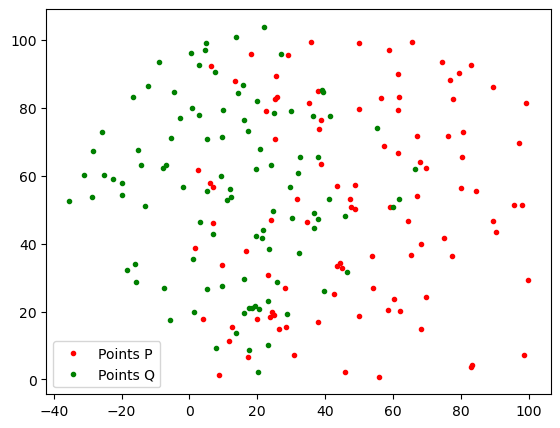

In [69]:
# Open the txt files
points_p = np.loadtxt(data_dir + 'points_p.txt')
points_q = np.loadtxt(data_dir + 'points_q.txt')

# Display the data
us.display_points([points_p, points_q], titles=['Points P', 'Points Q'])

In [70]:
# Compute the transformation parameters
scale, translation, rotation_angle = us.compute_transformation(points_p, points_q)

# Output the parameters
print(f"Scale (s): {scale}")
print(f"Translation (t): {translation}")
print(f"Rotation angle (θ) in degrees: {rotation_angle}")

Scale (s): 0.8354531704659556
Translation (t): [17.12345059 -3.63120423]
Rotation angle (θ) in degrees: 48.41113798952755


# Direct transformation

Points P shape: (100, 2)
Points Q shape: (100, 2)


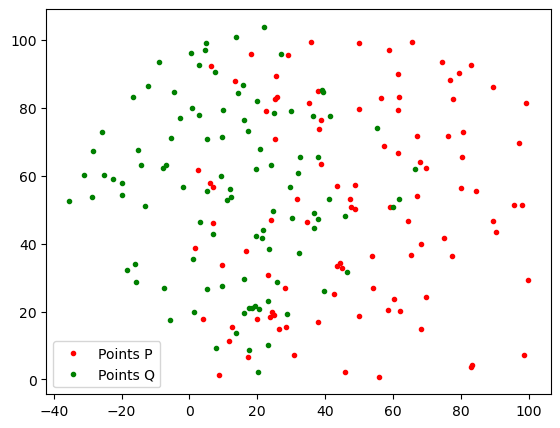

In [71]:
# Load the data
points_p = np.loadtxt(data_dir + 'points_p.txt')
points_q = np.loadtxt(data_dir + 'points_q.txt')

print(f"Points P shape: {points_p.shape}")
print(f"Points Q shape: {points_q.shape}")

# Display the data
us.display_points([points_p, points_q], titles=['Points P', 'Points Q'])


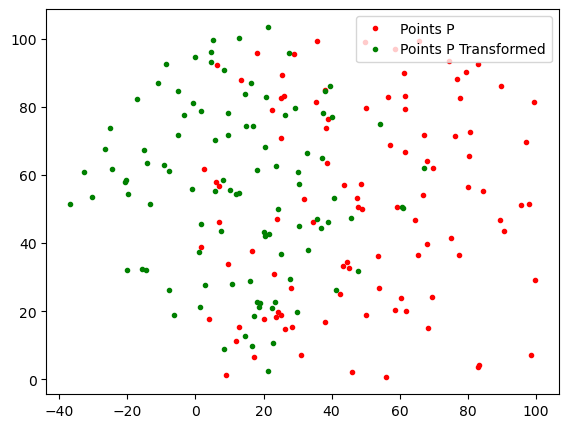

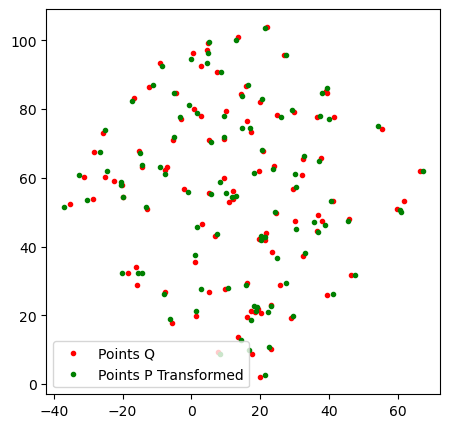

In [72]:
# Parameters
theta = 48.41113798952755 # degrees
theta = np.radians(theta) # Convert to radians

R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
t = np.array([17.12345059, -3.63120423]).reshape((2,1))
s = 0.8354531704659556

# Transform the points
points_p_transformed = s * np.dot(R, points_p.T).T + t.T

# Display the data
us.display_points([points_p, points_p_transformed], titles=['Points P', 'Points P Transformed'])
us.display_points([points_q, points_p_transformed], titles=['Points Q', 'Points P Transformed'])

# Inverse transformation

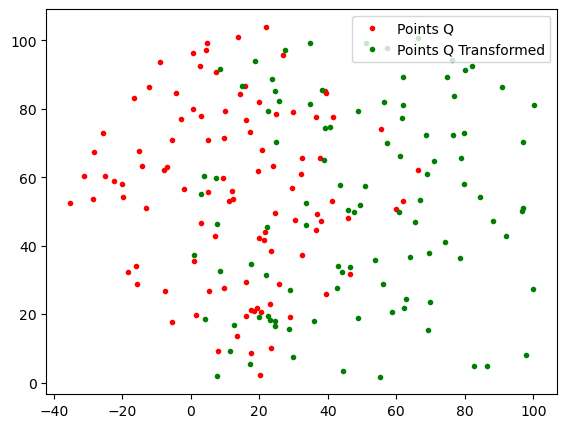

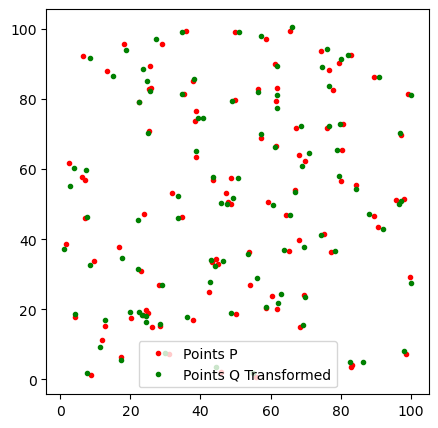

In [73]:
# Parameters
theta = 48.41113798952755  # degrees
theta = np.radians(theta)  # Convert to radians

R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
t = np.array([17.12345059, -3.63120423]).reshape((2, 1))
s = 0.8354531704659556

# Ensure t is broadcastable
t = t.reshape((2,))

# Transform the points
points_q_transformed = (R.transpose() @ (points_q.T - t[:, np.newaxis]) / s).T

# Display the data
us.display_points([points_q, points_q_transformed], titles=['Points Q', 'Points Q Transformed'])
us.display_points([points_p, points_q_transformed], titles=['Points P', 'Points Q Transformed'])

In [74]:
# Distance between transformed points

# Array with the distances between the points
distances = np.sqrt(((points_p - points_q_transformed)**2).sum(axis=0))

# Number of points with distance more than 2
n = (distances > 2).sum()
print(f'Number of points with distance more than 2: {n}')

Number of points with distance more than 2: 2


# From covariance matrix

In [75]:
def compute_rotation_from_covariance(C):
    """
    Computes the rotation matrix and angle from a given covariance matrix.

    Parameters:
    C (numpy.ndarray): 2x2 covariance matrix

    Returns:
    R (numpy.ndarray): 2x2 rotation matrix
    angle (float): rotation angle in degrees
    """
    # Perform Singular Value Decomposition (SVD)
    U, _, Vt = np.linalg.svd(C)
    
    # Compute the rotation matrix
    R = np.dot(U, Vt)
    
    # Ensure a proper rotation matrix (not a reflection)
    if np.linalg.det(R) < 0:
        Vt[1,:] *= -1
        R = np.dot(U, Vt)
    
    # Extract the rotation angle in radians
    angle_radians = np.arctan2(R[1, 0], R[0, 0])
    
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    
    return R, angle_degrees

In [76]:
C = np.array([[191955, -937044],[552183, 379358]])

rotation_matrix, rotation_angle = us.compute_rotation_from_covariance(C)
print("Rotation Matrix:\n", rotation_matrix)
print("Rotation Angle (degrees):", rotation_angle)

Rotation Matrix:
 [[ 0.35817796 -0.93365333]
 [ 0.93365333  0.35817796]]
Rotation Angle (degrees): 69.01165964850453
